### 課題2
以下の小問の(1)-(5)を解答せよ．

1. 上記のコードにおける畳込み層の順伝搬，逆伝搬の計算方法を説明せよ．さらに，自分で用意した画像に対して，上記のコードを実行せよ．
1. モデルパラメータ（例えば，10->20) を変化させて，結果を比較せよ．(特に最終loss値)
1. 学習率を変化させて挙動を観察せよ．
1. 1,2層にReLUを入れた場合と，3層ともReLUなしの場合の結果を比較せよ．
1. モーメンタムSDGに変更して，ノーマルなSDGとの違いを観察せよ．

### 【課題2: 任意発展課題】
興味のある人は，例えば，以下のような拡張を行ってみよ．

1. 複数枚の学習画像(2～10枚程度)に対応させて，lossの下がり方の違いについて観察せよ．random shuffleは入れても入れなくてもよい．
1. Adam, AdaGrad のどちらか一方，もしくは両方を実装して比較せよ．
1. 最終層の活性化関数に tanhを利用せよ．
1. Batch Normalization Layerを追加せよ．
1. Max pooling layerを実装せよ．Average Pooling も実装するとなお良い．
1. 上記のmini-batch対応を行った後，cupy ライブラリを使って，GPUに対応させよ．
1. SoftMax関数を追加し，Max Pooling, Fcクラスと組み合わせて，MNISTやCIFAR-10のサブセットなど，分類タスクを行ってみよ．(minibatch単位の計算+cupyの利用がないとおそらく厳しい．)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
from IPython import display
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# カレントディレクトリの読み込みとカレントディレクトリへの移動
import sys
sys.path.append(f'/content/drive/My Drive/system/')
import os
os.chdir(f'/content/drive/My Drive/system/myanswer')

In [4]:
class Conv:
    def __init__(self, c, h, w, n_filter, pad=0, stride=1, relu=True, seed=0):
        self.filter = (c,w,h)
        self.filter_c = c; self.filter_h=h; self.filter_w=w
        self.n_filter = n_filter
        self.pad = pad
        self.stride = stride
        self.relu= relu
        n_in = c * w * h
        self.n_in = n_in
        n_out = n_filter
        # 学習パラメータは, 重み行列w(=フィルタ), バイアス項b
        # サイズは以下の通り
        self.size_w = (n_out,n_in)
        self.size_b = (n_out,1)
        # w,b は全結合層の学習パラメータ．
        # ReLuも全結合の中にいれてある．
        # ReLU=Trueのときは，Heの初期値．Falseのときは，Xavierの初期値とする．
        # xは直前のforward計算時の入力値．BPの計算時に必要． 
        np.random.seed(seed) # 同じ初期値を再現できるように seed を指定します．
        if relu:
            self.w = np.random.normal(0, math.sqrt(2.0/n_in), self.size_w) # Heの初期値
            self.relu0 = None # ReLUの順伝搬時に０以下で値が伝搬されない要素のインデックスを記録．BP時に利用．
        else:
            self.w = np.random.normal(0, math.sqrt(1.0/n_in), self.size_w) # Xavierの初期値   
        self.b = np.zeros((n_out,1))
        self.x = np.zeros((n_in,1))
        # 誤差逆伝搬(Back-Propagation時の勾配を記録する変数)
        self.dEdx = np.zeros((n_in,1)) # dE/dx を表す　BPの時に直前レイヤに伝わる勾配でδと表現されます．
        self.dEdw = np.zeros((n_out,n_in)) # dE/dw を表す
        self.dEdb = np.zeros((n_out,1)) # dE/db を表す
        self.count = 0
        # MomentumSGDの初期設定
        self.mdw = np.zeros((n_out,n_in))
        self.mdb = np.zeros((n_out,1))

        # Adamの初期設定
        self.mw = np.zeros((n_out, n_in))
        self.vw = np.zeros((n_out, n_in))
        self.mb = np.zeros((n_out, 1))
        self.vb = np.zeros((n_out, 1))

        # Adagradの初期設定
        self.hw = np.zeros((n_out, n_in))
        self.hb = np.zeros((n_out, 1))

    # forward は __call__ を使って定義する．im2col + 行列積和．
    def __call__(self,input_):   # 入力はfeature map
        x,out_h,out_w = self.im2col(input_) # x のサイズは (self.n_in, out_h*out_w)
        self.x = x
        self.out_h = out_h
        self.out_w = out_w
        # w のサイズは，(n_filter, n_in), よって y のサイズは (n_filter,out_h*out_w)
        self.y = np.dot(self.w, x) + self.b
        # ReLUは，値が0以下の要素は，0とする．0とした要素のインデックスは relu0に記録し，BP時に勾配を伝搬させない．
        if self.relu:
            self.relu0= self.y<=0
            self.y[self.relu0] = 0
        # 最後に，(n_filter,out_h,out_w) にreshape
        return np.reshape(self.y,(self.n_filter,out_h,out_w))

    # backward は，dE/dy を受け取って，dE/dx を出力．内部では，dE/dw, dE/db を更新
    def backward(self, dEdy0):
        dEdy = np.reshape(dEdy0,(self.n_filter,self.out_h*self.out_w))
        # 順伝搬時に値が0以下だった要素は勾配を0として，勾配伝搬しない．
        if self.relu:
            dEdy[self.relu0] = 0
        dydx = np.transpose(self.w)  # dWx/dx= np.transpose(W) であることより．
        dydw = np.transpose(self.x)  # dWx/dW= np.transpose(x) 
        # dydb = np.ones((self.n_out,1))   #  db/db = np.ones((n_out,1))　１なので特に計算しない．
        # dEdw, dEdb に勾配を加算．dEdx (δ)は前層へ伝搬する勾配で，backwardの返り値とする．
        self.dEdx = np.dot(dydx, dEdy)
        self.dEdw += np.dot(dEdy, dydw)
        self.dEdb += np.c_[np.sum(dEdy, axis=1)]  # channelごとにfeature map 全体が1つのバイアスに対応するので channelごとにsumします．
        # 勾配の平均を取るために，足した勾配のサンプル数を記録．
        # conv の場合は，フィルタを適用した回数．つまり，出力feature mapの画素数
        self.count += (self.out_h*self.out_w)  
        # 最後に，col2imでfeature mapに対応するδを求める
        out=self.col2im(self.dEdx)
        return out

    # im2col は，feature map を　縦が1回の畳み込みに必要な局所画像サイズ(filter_c*filter_h*filter_w)，
    # 横が(out_h*out_w) になる行列に変換する関数 
    def im2col(self,input_):
        c, h, w = input_.shape
        out_h = (h + 2*self.pad - self.filter_h)//self.stride + 1
        out_w = (w + 2*self.pad - self.filter_w)//self.stride + 1
        # padding 分をzero paddingで追加したimを生成
        im = np.pad(input_, [(0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        # filterの各x,yの位置ごとに，対応するfeature mapの値を格納し，
        # 最後に transpose -> reshape で，im2col出力行列を生成
        col = np.zeros((c, self.filter_h, self.filter_w, out_h, out_w))
    
        for y in range(self.filter_h):
            y_max = y + self.stride*out_h
            for x in range(self.filter_w):
                x_max = x + self.stride*out_w
                # filterの位置に応じてずらしてfeature mapをコピー
                # stride>1の時は飛ばしてfeature mapをコピー
                col[:, y, x, :, :] = im[:, y:y_max:self.stride, x:x_max:self.stride]
        # チャネル軸を1番目から3番目に移動して，reshapeして，(filter_c,out_h*out_w)とする
        col = col.transpose(1, 2, 0, 3, 4).reshape((self.n_in, out_h*out_w))
        return col,out_h,out_w

    # col2im は，im2col形式の勾配δをfeature map形式に変換する．逆伝搬で使用．
    def col2im(self,col):
        col_h, col_w = col.shape # (filter_c*filter_h*filter_w, out_h*out_w)
        h = (self.out_h-1)*self.stride + self.filter_h
        w = (self.out_w-1)*self.stride + self.filter_w
        c = self.filter_c
    
        # サイズ(x,h,w)の im 行列を0で初期化
        im = np.zeros((c,h,w))
        # feature map colの各場所について，勾配を対応するimの場所に加算する
        for j in range(self.out_h):
            for i in range(self.out_w):
                im[:, j:j+self.filter_h, i:i+self.filter_w] += np.reshape(col[:, j * self.out_w + i],(c,self.filter_h,self.filter_w))
        return im[:,self.pad:h-self.pad,self.pad:w-self.pad]        

    # 以下は，updater で，Fcと同じ実装です．ちゃんと実装するなら，super classにする方がいいでしょう．
    # 勾配をクリア
    def clear_grad(self):
        self.dEdw = 0
        self.dEdb = 0
        self.count = 0

    # 勾配法で重みをアップデート．countで割って，足しこんだ勾配のサンプル数で平均を取る
    def update(self, lr=0.001):
        self.w -= self.dEdw/self.count * lr
        self.b -= self.dEdb/self.count * lr
        self.clear_grad()
    
    # 慣性項（モーメンタム項）付きの勾配法 課題1の5
    def updatem(self, lr=0.001, mu=0.9):
        self.mdw = mu * self.mdw - (self.dEdw/self.count) * lr
        self.mdb = mu * self.mdb - (self.dEdb/self.count) * lr
        self.w += self.mdw
        self.b += self.mdb
        self.clear_grad()
    
    # adagrad (課題2 任意発展課題の2)
    def update_adagrad(self, lr=0.01):
        self.hw += (self.dEdw/self.count)**2
        self.hb += (self.dEdb/self.count)**2
        self.w -= lr * (self.dEdw/self.count)/(np.sqrt(self.hw) + 1e-7)
        self.b -= lr * (self.dEdb/self.count)/(np.sqrt(self.hb) + 1e-7)
        self.clear_grad()

    # adam (課題2 任意発展課題の2)        
    def update_adam(self, lr=0.001, beta1=0.9, beta2=0.99):
        self.mw = beta1 * self.mw + (1 - beta1) * (self.dEdw/self.count)
        self.vw = beta2 * self.vw + (1 - beta2) * (self.dEdw/self.count)**2
        
        self.mb = beta1 * self.mb + (1 - beta1) * (self.dEdb/self.count)
        self.vb = beta2 * self.vb + (1 - beta2) * (self.dEdb/self.count)**2
        
        mhat_w = self.mw / (1 - beta1**self.count)
        vhat_w = self.vw / (1 - beta2**self.count)
        
        mhat_b = self.mb / (1 - beta1**self.count)
        vhat_b = self.vb / (1 - beta2**self.count)
        
        self.w -= lr * mhat_w/(np.sqrt(vhat_w) + 1e-7)
        self.b -= lr * mhat_b/(np.sqrt(vhat_b) + 1e-7)
        
        self.clear_grad()

In [5]:
from skimage import feature,filters
from PIL import Image
import os
import sys

In [6]:
def convert_image_to_matrix(img_path, method="canny"):
    """
    入力画像を配列化しエッジを抽出した画像を配列化
    グレースケール化した画像を配列化する関数
    
    入力
    img_path(str): 画像のファイルパス
    method: エッジ抽出の方法 cannyかsobelを想定
    
    出力
    img: 配列化した画像
    edge: エッジ抽出した画像
    grey: グレースケール化した画像
    """
    img_org = Image.open(img_path).resize((320,240))
    img = np.array(img_org, dtype=np.uint8)
    gray = np.array(img_org.convert('L'), dtype=np.uint8)
    if method == "canny":
        edge = feature.canny(gray,sigma=2)  # Canny でエッジ抽出
        edge = edge * 255
        return img, edge, gray
    elif method == "sobel":
        edge = filters.sobel(gray) # Sobel でエッジ抽出
        edge = edge * 255
        return img, edge, gray
    else:
        raise ValueError("Invalid edge extraction method")

In [7]:
# エッジ検出フィルタ，グレースケール化フィルタの切り替え
def convert_pixel_value(img, edge, gray, use_edge=True):
    """
    画像を行列に変換
    入力 
    img:入力画像
    edge: エッジ抽出した画像
    gray: グレースケール化した画像
    use_edge(bool): エッジ化した画像を使うかどうか
    
    出力
    [-1,1)の範囲に制限した入力画像と出力画像
    
    """
    if use_edge:
        gt = edge
    else:
        gt = gray

    plt.subplot(121)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(122)
    plt.axis("off")
    
    plt.imshow(gt,plt.cm.gray)

    # 画素値が [-1,1) の範囲の値になるように変換
    input_  = (np.asarray(img, dtype=np.float32).transpose(2,0,1)-128)/128.0
    output = (np.expand_dims(np.asarray(gt, dtype=np.float32),0)-128)/128.0
    return input_, output

In [8]:
def show_learning_result(input_, output, c1, c2, c3, lr=0.001, mu=0.9, beta1=0.9, beta2=0.99, num_epoch=200, optimizer="sgd",
                         is_relu=True, param_pattern="1"):
    """
    fc1: 畳み込み層の1層目
    fc2: 畳み込み層の2層目
    fc3:畳み込み層の3層目
    lr(float): 学習率
    mu(float): 慣性項の係数 momentum_sgdで使用
    beta1(float): adamで利用するパラメータ
    beta2(float): adamで利用するパラメータ
    num_epoch(int): エポック数
    optimizer(list): 勾配の最適化方法 ["sgd", "momentum_sgd", "adam", "adagrad"]という文字列を代入することを想定
    is_relu(bool): reluを使うかどうか(使う:True，使わない:False) 結果の画像を保存するために利用
    param_pattern(str):畳み込み層のパラメータの設定パターン 以下の3パターンを想定．結果の画像を保存するために利用
    1: c1 = Conv(3,3,3,10,pad=1)，c2 = Conv(10,3,3,10,pad=1)，c3 = Conv(10,3,3,1,pad=1,relu=0)
    2: c1 = Conv(3,3,3,10,pad=1)，c2 = Conv(10,3,3,100,pad=1)，c3 = Conv(100,3,3,1,pad=1,relu=0)
    3: c1 = Conv(3,3,3,10,pad=1)，c2 = Conv(10,3,3,5,pad=1)，c3 = Conv(5,3,3,1,pad=1,relu=0)
    """
    losses = np.array([])
    ep = np.array([])

    # 表示エリアの設定
    fig = plt.figure()
    fig1 = fig.add_subplot(121)
    fig2 = fig.add_subplot(122)

    for epoch in range(num_epoch):
        if epoch > 0 and epoch %100 ==0:
            lr *= 0.1
        # 順伝搬計算
        y = c3(c2(c1(input_)))
        # 誤差微分値，誤差値を計算します． 
        dEdx = y - output
        loss = np.sum(dEdx**2)*0.5/(y.shape[1] * y.shape[2])
        # dEdx (δ)を計算して，逆伝搬します．
        dEdx = c3.backward(dEdx)
        dEdx = c2.backward(dEdx)
        dEdx = c1.backward(dEdx)
        # 順伝搬，逆伝搬を行ったら，SGDで重みを更新
        # out_h*out_w 分の順伝搬の勾配がすべて合計されていますので，
        # batchsize 1 でも，実質batchisizeは out_h*out_w (例えば，320*240だと76800)になります．
        if optimizer == "sgd":
            c1.update(lr)
            c2.update(lr)
            c3.update(lr)
        elif optimizer == "momentum_sgd":
            c1.updatem(lr, mu)
            c2.updatem(lr, mu)
            c3.updatem(lr, mu)
        elif optimizer == "adam":
            c1.update_adam(lr, beta1, beta2)
            c2.update_adam(lr, beta1, beta2)
            c3.update_adam(lr, beta1, beta2)
        elif optimizer == "adagrad":
            c1.update_adagrad(lr=0.01)
            c2.update_adagrad(lr=0.01)
            c3.update_adagrad(lr=0.01)

        losses = np.append(losses,loss)
        ep = np.append(ep,epoch)
        if epoch % 10 == 0:
            display.clear_output(wait = True)
            fig1.axis([0, num_epoch, 0, 0.5])
            fig1.plot(ep,losses,"r")
            out = (y.squeeze()+1.0)*128.0 # 表示するときは，[0.256)に戻します．
            fig2.axis("off")
            fig2.imshow(out,cmap="gray",vmin=0,vmax=255)
            display.display(fig)
            if epoch < num_epoch - 1:
                fig2.cla()

    display.clear_output(wait = True)
    fig1.plot(ep,losses,"r")
    fig2.imshow(out,cmap="gray",vmin=0,vmax=255)
    os.makedirs('../result/convolution_scratch/', exist_ok=True)
    fig.savefig("../result/convolution_scratch/{}_lr{}_relu{}_param{}.png".format(optimizer, lr, str(is_relu), param_pattern),
                transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.0)
    print("loss: {}".format(loss))

### 課題2 1.上記のコードにおける畳込み層の順伝搬，逆伝搬の計算方法を説明せよ．さらに，自分で用意した画像に対して，上記のコードを実行せよ．
順伝搬，逆伝搬の計算を説明．

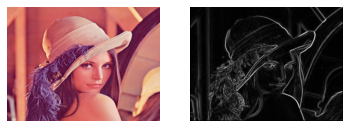

In [9]:
# 自分で用意した画像で実行
img_myimg, edge_myimg, gray_myimg = convert_image_to_matrix("../figure/lena.jpg","sobel")
input_myimg, output_myimg =  convert_pixel_value(img_myimg, edge_myimg, gray_myimg)

loss: 0.2990431856473176


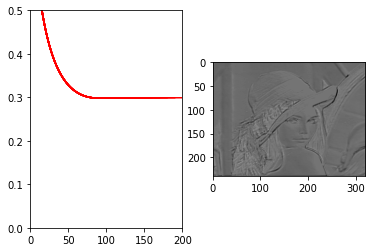

In [10]:
c1 = Conv(3,3,3,10,pad=1)
c2 = Conv(10,3,3,10,pad=1)
c3 = Conv(10,3,3,1,pad=1,relu=0)
show_learning_result(input_myimg, output_myimg, c1, c2, c3)

### 課題2 2. モデルパラメータ（例えば，10->20) を変化させて，結果を比較せよ．(特に最終loss値)

loss: 0.028003480883415695


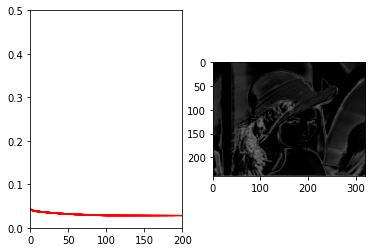

In [11]:
c1_changed = Conv(3,3,3,10,pad=1)
c2_changed = Conv(10,3,3,100,pad=1)
c3_changed = Conv(100,3,3,1,pad=1,relu=0)

show_learning_result(input_myimg, output_myimg, c1_changed, c2_changed, c3_changed, param_pattern="2")

loss: 0.4102807648275653


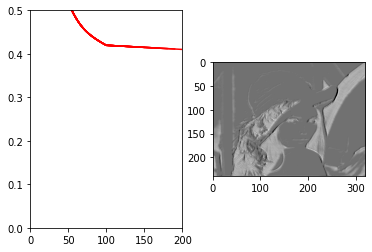

In [12]:
c1_changed = Conv(3,3,3,10,pad=1)
c2_changed = Conv(10,3,3,5,pad=1)
c3_changed = Conv(5,3,3,1,pad=1,relu=0)

show_learning_result(input_myimg, output_myimg, c1_changed, c2_changed, c3_changed, param_pattern="3")

### 課題2 3. 学習率を変化させて挙動を観察せよ．

loss: 0.008594911306684608


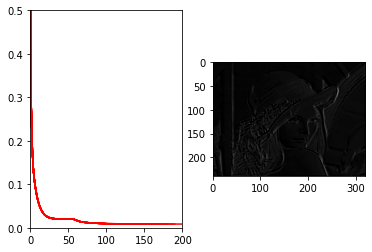

In [13]:
c1 = Conv(3,3,3,10,pad=1)
c2 = Conv(10,3,3,10,pad=1)
c3 = Conv(10,3,3,1,pad=1,relu=0)

# デフォルトの値0.001よりも学習率を高くする
show_learning_result(input_myimg, output_myimg, c1, c2, c3, lr=0.1)

loss: 0.7503125095945941


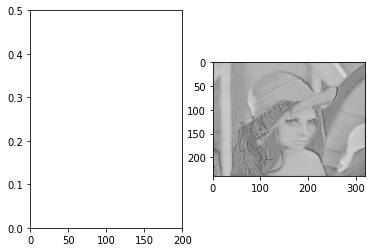

In [14]:
c1 = Conv(3,3,3,10,pad=1)
c2 = Conv(10,3,3,10,pad=1)
c3 = Conv(10,3,3,1,pad=1,relu=0)

# デフォルトの値0.001よりも学習率を低くする
show_learning_result(input_myimg, output_myimg, c1, c2, c3, lr=10**-5)

### 課題2 4. 1,2層にReLUを入れた場合と，3層ともReLUなしの場合の結果を比較せよ．
1,2層にReLUを入れた場合の結果は課題2.1を参照


loss: 0.17524519794364588


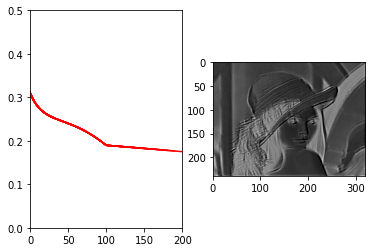

In [15]:
c1_without_relu = Conv(3,3,3,10,pad=1,relu=0)
c2_without_relu = Conv(10,3,3,10,pad=1,relu=0)
c3_without_relu = Conv(10,3,3,1,pad=1,relu=0)

show_learning_result(input_myimg, output_myimg, c1_without_relu, c2_without_relu, c3_without_relu)

### 課題2 5. モーメンタムSDGに変更して，ノーマルなSGDとの違いを観察せよ．
ノーマルなSGDの結果は課題2.1を参照

loss: 0.05625285413322751


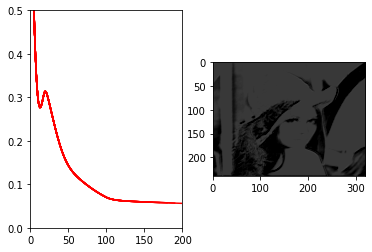

In [16]:
c1 = Conv(3,3,3,10,pad=1)
c2 = Conv(10,3,3,10,pad=1)
c3 = Conv(10,3,3,1,pad=1,relu=0)

show_learning_result(input_myimg, output_myimg, c1, c2, c3, optimizer="momentum_sgd")

### 【課題2: 任意発展課題】
1. Adam, AdaGrad のどちらか一方，もしくは両方を実装して比較せよ．
* Adamを実行した場合．(モデルのパラメータと入力画像は，課題2.1と同じ)

loss: 0.01698752247361741


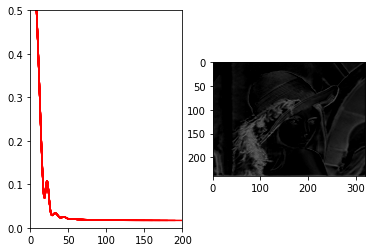

In [17]:
c1_adam = Conv(3,3,3,10,pad=1)
c2_adam = Conv(10,3,3,10,pad=1)
c3_adam = Conv(10,3,3,1,pad=1,relu=0)

show_learning_result(input_myimg, output_myimg, c1_adam, c2_adam, c3_adam, optimizer="adam")

* Adagradを実行した場合．(モデルのパラメータと入力画像は，課題2.1と同じ)

loss: 0.011846484897571062


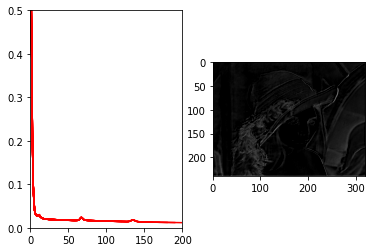

In [18]:
c1_adagrad = Conv(3,3,3,10,pad=1)
c2_adagrad = Conv(10,3,3,10,pad=1)
c3_adagrad = Conv(10,3,3,1,pad=1,relu=0)

show_learning_result(input_myimg, output_myimg, c1_adagrad, c2_adagrad, c3_adagrad, optimizer="adagrad")